# Medical Text Exploratory Data Analysis

* Author: Kevin Chuang [@k-chuang](https://www.github.com/k-chuang)
* Created on: September 21, 2018
* Goal: Given a medical abstract, classify condition of patient (5 classes) using K-Nearest Neighbors. 
* Description: Explore and analyze the data using visualizations and other techniques. 

-----------

## Import libraries

In [1]:
__author__ = 'Kevin Chuang (https://www.github.com/k-chuang)' 

# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

# Preprocessing
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer

# Text Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

# Natural Language Processing
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

# Metrics
from sklearn.metrics import f1_score

# Utilities
import string
import math
from operator import itemgetter 
from collections import Counter, defaultdict
from scipy.sparse import csr_matrix
import scipy.sparse as sp

%matplotlib inline

## Load data

In [2]:
train_df = pd.read_csv('../data/train.dat', sep='\t', header=None, names=['Label', 'Abstract'])
test_df = pd.read_csv('../data/test.dat', sep='\t', header=None, names=['Abstract'])
submission_df = pd.read_csv('../data/format.dat', header=None, names=['Labels'])

In [3]:
train_df.head()

,Label,Abstract
0,4,Catheterization laboratory events and hospital...
1,5,Renal abscess in children. Three cases of rena...
2,2,Hyperplastic polyps seen at sigmoidoscopy are ...
3,5,Subclavian artery to innominate vein fistula a...
4,4,Effect of local inhibition of gamma-aminobutyr...


In [4]:
test_df.head()

,Abstract
0,Excision of limbal dermoids. We reviewed the c...
1,Bell's palsy. A diagnosis of exclusion. In cas...
2,Retained endobronchial foreign body removal fa...
3,Recurrent buccal space abscesses: a complicati...
4,Intracranial fibromatosis. Fibromatoses are un...


## Data Exploration

- View a sample of the medical abstract text
    - Initial observations of medical abstract text
        - There are a lot of complex medical terms (e.g. acute myocardial infarction) 
        - There seems to be a lot of n = some integer (e.g. n = 100)
        - There seems to be a lot of percentages (e.g. 55%)
- Imbalanced Classes
    - Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration.
    - Need to configure model or artifically balance the dataset (oversampling under-represented classes and undersampling over-represented classes)
- Classes?
    - 1: Neoplasms
    - 2: Digestive System Diseases
    - 3: Nervous System Diseases
    - 4: Cardiovascular Diseases
    - 5: General Pathological conditions

In [5]:
train_df['Abstract'][0]

'Catheterization laboratory events and hospital outcome with direct angioplasty for acute myocardial infarction To assess the safety of direct infarct angioplasty without antecedent thrombolytic therapy, catheterization laboratory and hospital events were assessed in consecutively treated patients with infarctions involving the left anterior descending (n = 100 patients), right (n = 100), and circumflex (n = 50) coronary arteries. The groups of patients were similar for age (left anterior descending coronary artery, 59 years; right coronary artery, 58 years; circumflex coronary artery, 62 years), patients with multivessel disease (left anterior descending coronary artery, 55%; right coronary artery, 55%; circumflex coronary artery, 64%), and patients with initial grade 0/1 antegrade flow (left anterior descending coronary artery, 79%; right coronary artery, 84%; circumflex coronary artery, 90%). Cardiogenic shock was present in eight patients with infarction of the left anterior descen

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14438 entries, 0 to 14437
Data columns (total 2 columns):
Label       14438 non-null int64
Abstract    14438 non-null object
dtypes: int64(1), object(1)
memory usage: 225.7+ KB


In [7]:
# Imbalanced classes
train_df['Label'].value_counts()

5    4805
1    3163
4    3051
3    1925
2    1494
Name: Label, dtype: int64

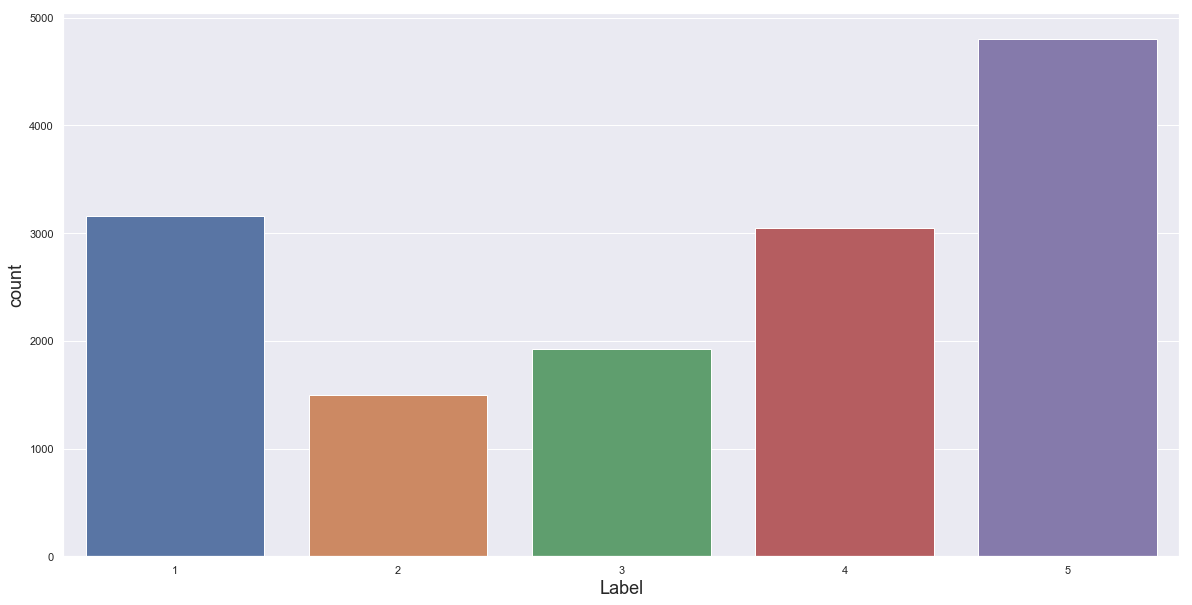

In [8]:
# Plot distribution of classes
sns.set(rc={"figure.figsize": (20.0, 10.0), "axes.labelsize": 18})
sns.countplot(x='Label', data=train_df)

In [9]:
# Check for null abstracts
train_df.Abstract.isnull().sum()

0

In [10]:
# Check for null labels
train_df.Label.isnull().sum()

0

In [11]:
# Check for duplicated instances
train_df.duplicated().sum()

0

In [12]:
# Check for duplicated Abstracts
train_df.Abstract.duplicated(keep=False).sum()

6140

In [13]:
# Groupby the duplicated Abstracts to visualize
pd.concat(g for _, g in train_df.groupby("Abstract") if len(g) > 1)

,Label,Abstract
3072,1,'Locked-in syndrome' for 27 years following a ...
3377,3,'Locked-in syndrome' for 27 years following a ...
11334,5,'Locked-in syndrome' for 27 years following a ...
1121,4,(A)typical symptoms during single needle dialy...
1331,5,(A)typical symptoms during single needle dialy...
4396,2,(A)typical symptoms during single needle dialy...
4322,3,7th nerve palsy after extradural blood patch. ...
7803,5,7th nerve palsy after extradural blood patch. ...
4604,3,99TCm-HMPAO SPECT studies in traumatic intrace...
8978,5,99TCm-HMPAO SPECT studies in traumatic intrace...


In [14]:
# Check label with most duplicated data
pd.concat(g for _, g in train_df.groupby("Abstract") if len(g) > 1)['Label'].value_counts()

5    2411
4    1090
1     968
3     876
2     795
Name: Label, dtype: int64

In [15]:
# Combine train and test abstracts to use for building vectorizer
abstract_df = pd.concat([train_df['Abstract'], test_df['Abstract']])

In [16]:
abstract_df.shape

(28880,)

## Data Exploration & Visualization

- Going to use `Bag of Words` approach
    - presence of words (frequency or count) is taken into consideration & order is ignored
    - BOW basically breaks up the note into the individual words and counts how many times each word occurs.
- Tokenizer and a vectorizer. 
    - The tokenizer breaks a single abstract into a list of words and a vectorizer takes a list of words and counts the words.
- `Tokenizer`:
    - Remove punctuation & numbers
    - Lowercase everything
    - Two approaches for tokenization
        - Goal is reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.
        - `WordNetLemmatizer`
            - Lemmatize all the text (e.g. women will become woman)
                - Lemmatization is the process of converting the words of a sentence to its dictionary form. 
        - `PorterStemmer`
            - Stem all the text
                - Stemming is the process of converting words to the stem (root) of the word
- `Vectorizer`:
    - General process of turning a collection of text documents into numerical feature vectors. 
    - This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation. 
    - Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.
    - `CountVectorizer`
        - Encodes a vector with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.
        - `vocabulary_` is a dict/mapping of the terms to their indices in the document-term matrix, not the counts.
    - `TfidfVectorizer`
        - Convert a collection of raw documents to a matrix of TF-IDF features.
            - Normalizing and weighting with diminishing importance tokens that occur in the majority of samples / documents.
        - TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.
            - *This can be extremely useful for this problem, since we have 5 categories we are trying to classify and thus certain categories (medical conditions) may have words in the medical abstract that are unique to the condition*
        - The resulting tf-idf vectors are then normalized by the Euclidean norm (L2)
        - **Since the medical text data have a lot of multi-word expressions (e.g. *left anterior descending coronary artery*), I will use N-grams (where N >= 1) to keep the local positioning of these important words **
            - Experimented with N-grams, and it seems 1-gram, 2-gram, 3-gram, and 4-grams produce best results

In [17]:
def lemma_tokenizer(text):
    '''Tokenize text into a list of preprocessed words '''
    
    # Create a string with all punctuations & digits concatenated
    num_and_punc = string.punctuation + string.digits
    
    # Create a mapping to space using string above for each num/punc & return a translation table with mapping
    t_table = str.maketrans(dict.fromkeys(num_and_punc, " "))
    
    # Lower text and use translation table to remove all punctuation and digits
    text = text.lower().translate(t_table)
    
    # Use Lemma tokenizer to tokenize the words
    lemma = WordNetLemmatizer()
    lemmas = [lemma.lemmatize(word.strip()) for word in text.split()]
    
    return lemmas

def word_tokenizer(text):
    '''Tokenize text into a list of preprocessed words '''
    
    # Create a string with all punctuations & digits concatenated
    num_and_punc = string.punctuation + string.digits
    
    # Create a mapping to space using string above for each num/punc & return a translation table with mapping
    t_table = str.maketrans(dict.fromkeys(num_and_punc, " "))
    
    # Lower text and use translation table to remove all punctuation and digits
    text = text.lower().translate(t_table)
    
    tokens = word_tokenize(text)
    return tokens

def tokenizer(text):
    '''Tokenize text into a list of preprocessed words '''
    
    # Create a string with all punctuations & digits concatenated
    num_and_punc = string.punctuation + string.digits
    
    # Create a mapping to space using string above for each num/punc & return a translation table with mapping
    t_table = str.maketrans(dict.fromkeys(num_and_punc, " "))
    
    # Lower text and use translation table to remove all punctuation and digits
    text = text.lower().translate(t_table)
    # Best Stemmer for this dataset (Tested)
    stemmer = PorterStemmer()
#     stemmer = SnowballStemmer("english")
#     stemmer = LancasterStemmer()
    stems = [stemmer.stem(word.strip()) for word in text.split()]
    return stems

In [18]:
print(tokenizer(train_df['Abstract'][1]))

['renal', 'abscess', 'in', 'children', 'three', 'case', 'of', 'renal', 'abscess', 'in', 'children', 'are', 'describ', 'to', 'illustr', 'the', 'variabl', 'present', 'featur', 'an', 'addit', 'pediatr', 'case', 'report', 'over', 'the', 'past', 'ten', 'year', 'were', 'review', 'for', 'clinic', 'featur', 'and', 'therapi', 'fever', 'loin', 'pain', 'and', 'leukocytosi', 'were', 'common', 'present', 'featur', 'but', 'less', 'than', 'half', 'of', 'all', 'abscess', 'were', 'associ', 'with', 'either', 'an', 'abnorm', 'urinalysi', 'or', 'a', 'posit', 'urin', 'cultur', 'the', 'present', 'featur', 'were', 'sometim', 'confus', 'with', 'append', 'periton', 'or', 'a', 'wilm', 'tumor', 'an', 'organ', 'wa', 'identifi', 'in', 'case', 'escherichia', 'coli', 'in', 'children', 'and', 'staphylococcu', 'aureu', 'in', 'children', 'the', 'major', 'of', 'e', 'coli', 'infect', 'occur', 'in', 'girl', 'and', 'the', 'major', 'of', 's', 'aureu', 'infect', 'occur', 'in', 'boy', 'reflux', 'wa', 'document', 'in', 'patien

In [19]:
vec = CountVectorizer(tokenizer = word_tokenizer)
vec.fit(abstract_df)
X_train = vec.transform(train_df['Abstract'])

In [20]:
# Size is around 31869 unique words

len(vec.vocabulary_)

46832

In [21]:
vocab_names = vec.get_feature_names()

In [22]:
word_counts = np.asarray(X_train.sum(axis=0))

In [23]:
vocab_counts_df = pd.DataFrame.from_dict({'Word':vocab_names, 'Counts':word_counts.ravel()})

In [24]:
vocab_counts_df.head()

,Word,Counts
0,a,44049
1,aa,26
2,aaa,27
3,aab,7
4,aac,0


In [25]:
vocab_counts_df.sort_values(['Counts'], ascending=False).head(60)

,Word,Counts
42367,the,122496
29522,of,121285
1742,and,81967
20155,in,79406
0,a,44049
46403,with,43935
42859,to,43083
31172,patients,34444
46088,was,28455
46244,were,24358


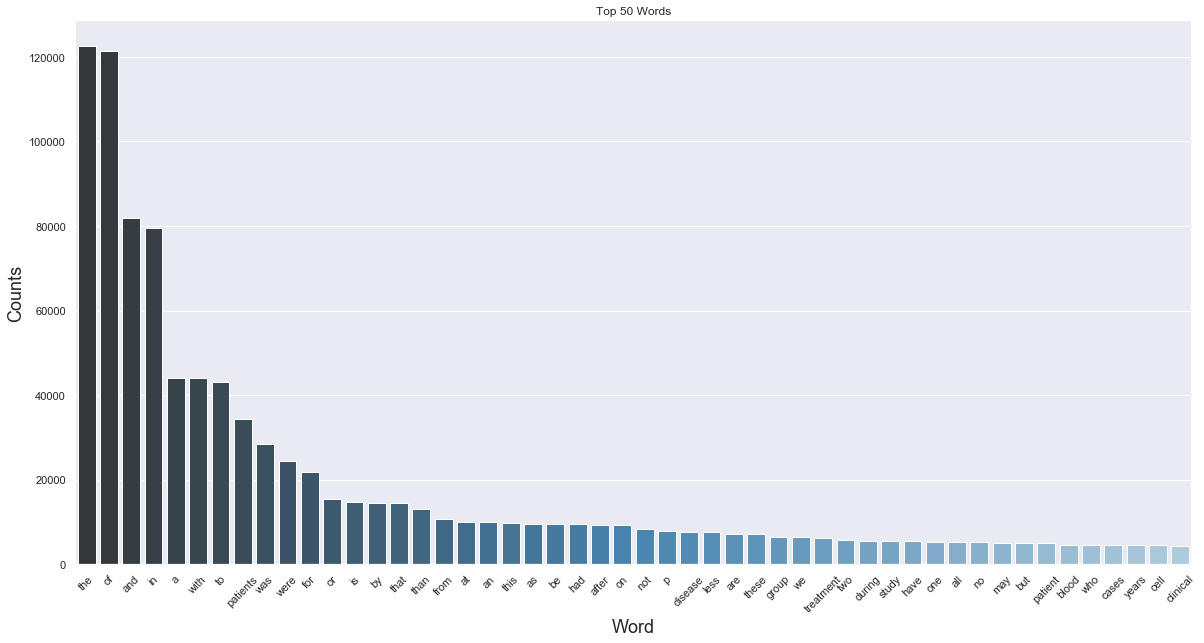

In [26]:
# Let's plot the top 50 most frequently occurring words

# Set the graph parameters
sns.set(rc={"figure.figsize": (20.0, 10.0), "axes.labelsize": 18})

top50 = vocab_counts_df.sort_values(['Counts'], ascending=False).iloc[:50]

ax = sns.barplot("Word", "Counts", data=top50, palette="Blues_d");
ax.set_title('Top 50 Words')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

### Stop words

- Stop words are words we do not want to use as features, and shall remove from our training
- These include words like `the` or `and` or `a` that are not very important
    - We will also use the English stop words form the standard sklearn package
- Fit new `CountVectorizer` with these stop words removed

In [27]:
# Use stop words from NLTK and sklearn corpus

# 153 stop words from NLTK
nltk_stop_words = stopwords.words('english')
# Combine stop words from all the stop word lists
stop_words = ENGLISH_STOP_WORDS.union(nltk_stop_words)

In [28]:
# 378 stop words
len(stop_words)

378

## Word Tokenizer

In [29]:
# Using idf

tfidf_vec = TfidfVectorizer(tokenizer = word_tokenizer, norm='l2', ngram_range=(1,2), sublinear_tf = True, min_df = 5,
                            stop_words = stop_words)
tfidf_vec.fit(abstract_df.values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=frozenset({'any', 'here', 'seem', 'take', "aren't", 'least', 'off', 'alone', 'describe', 'couldn', 'mustn', 'wouldn', 'therein', 'thus', 'whole', 'whose', 'won', 'i', 'couldnt', 'none', 'own', 'front', 'beyond', 'thin', 'thru', 'been', 'across', 'nothing', 'whence', 'yourself', 'most', 's...pon', 'this', 'whereby', 'hers', 'while', 'all', 'because', 'both', 'six', 'm', 'between', 'haven'}),
        strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function word_tokenizer at 0x117c09620>, use_idf=True,
        vocabulary=None)

In [30]:
X_train_tfidf = tfidf_vec.transform(train_df['Abstract'].values)
X_test_tfidf = tfidf_vec.transform(test_df['Abstract'].values)

In [31]:
print('There are %i features' % X_train_tfidf.shape[1])

There are 92523 features


In [32]:
Y_train = train_df['Label'].values

In [33]:
vocab_names = tfidf_vec.get_feature_names()

In [34]:
tfidf = np.mean(X_train_tfidf.toarray(), axis=0)

In [35]:
tfidf_df = pd.DataFrame.from_dict({'Word':vocab_names, 'TF-IDF':tfidf.ravel()})

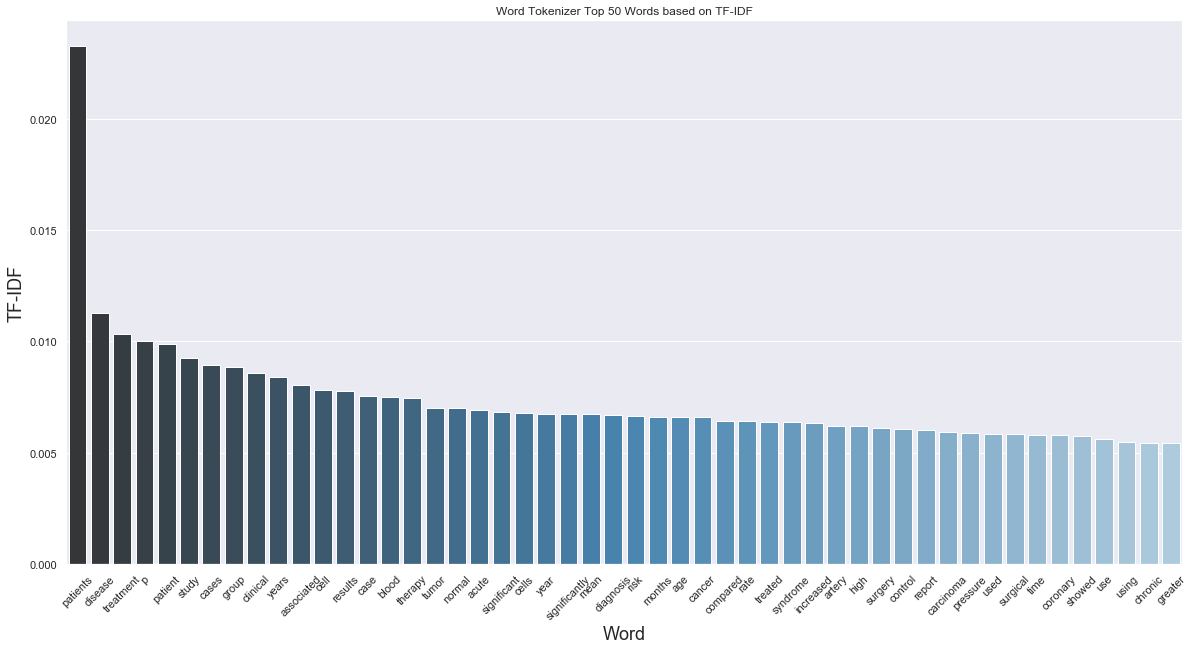

In [36]:
# Set the graph parameters
sns.set(rc={"figure.figsize": (20.0, 10.0), "axes.labelsize": 18})

tfidf_top50 = tfidf_df.sort_values(['TF-IDF'], ascending=False).iloc[:50]

ax = sns.barplot("Word", "TF-IDF", data=tfidf_top50, palette="Blues_d");
ax.set_title('Word Tokenizer Top 50 Words based on TF-IDF')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

In [37]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [38]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [39]:
top_feats_in_doc(X_train_tfidf, vocab_names, 0, top_n = 25)

,feature,tfidf
0,artery years,0.197674
1,circumflex coronary,0.190605
2,circumflex,0.185251
3,descending coronary,0.180272
4,catheterization laboratory,0.179072
5,right coronary,0.178250
6,anterior descending,0.174805
7,left anterior,0.174059
8,infarction left,0.168543
9,descending,0.163501


In [40]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [41]:
# Gives us the most important words across the whole corpus based on tfidf
top_mean_feats(X_train_tfidf, vocab_names, grp_ids=None, min_tfidf=0.1, top_n=15)

,feature,tfidf
0,children,0.002805
1,syndrome,0.002659
2,cancer,0.002401
3,coronary,0.002290
4,renal,0.002246
5,aortic,0.002224
6,breast,0.002186
7,carcinoma,0.002173
8,pain,0.002151
9,gastric,0.002109


In [42]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [43]:
class_top_tfidfs = top_feats_by_class(X_train_tfidf, Y_train, vocab_names, min_tfidf=0.1, top_n=25)

In [44]:
def plot_tfidf(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.gca().invert_yaxis()
        plt.subplots_adjust(bottom=0.09, right=0.99, left=0.05, top=0.95, wspace=0.52)
    plt.show()

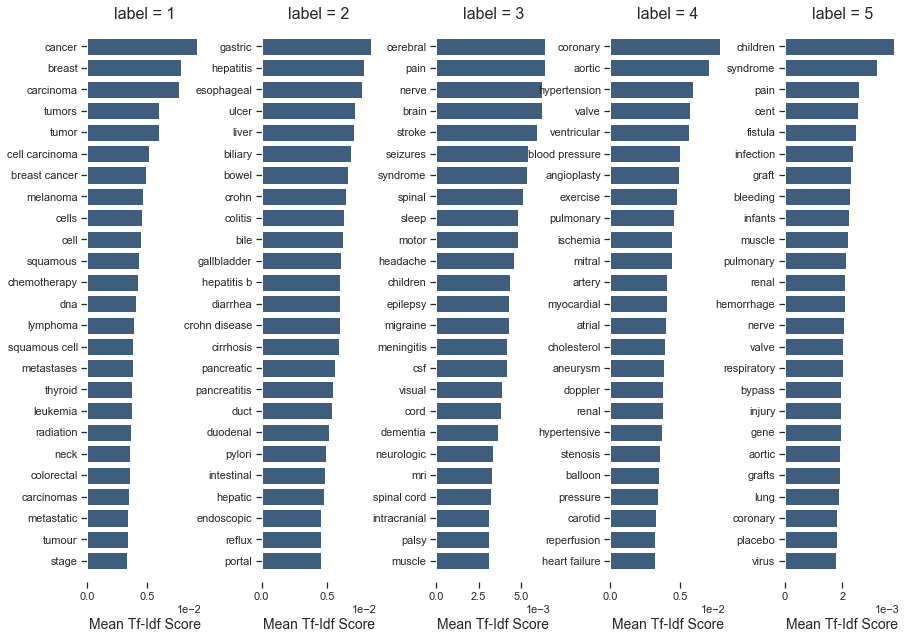

In [45]:
plot_tfidf(class_top_tfidfs)

## Chi Squared Statistical Test

- Visualize the top N terms that are most correlated with each medical condition/disease using Chi squared test
    - Selects n_features with highest values for the test chi-squared statistic
        - Could use for feature selection, but I am only using it for visualization
    - Chi-square test measures dependence between stochastic variables, so using this function “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification.
    - X^2 gives a measure of the distance between observed and expected frequencies.

In [46]:
N = 5
for i in sorted(train_df['Label'].unique()):
    features_chi2 = chi2(X_train_tfidf, train_df['Label'] == i)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vec.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("Class #%d:" % i)
    # Get last N values (np.argsort will return ascending values)
    print("  Most correlated unigrams:\n     *{}".format('\n     *'.join(unigrams[-N:])))
    print("  Most correlated bigrams:\n     *{}".format('\n     *'.join(bigrams[-N:])))

Class #1:
  Most correlated unigrams:
     *ileostomies
     *educating
     *tympanocentesis
     *shortages
     *turkey
  Most correlated bigrams:
     *occurred simultaneously
     *echocardiographic signs
     *loss long
     *echo pulse
     *secondary pain
Class #2:
  Most correlated unigrams:
     *anf
     *hyperpnea
     *ignoring
     *presume
     *pretranslational
  Most correlated bigrams:
     *ic antiarrhythmic
     *anf levels
     *hz patients
     *identifies group
     *case provides
Class #3:
  Most correlated unigrams:
     *extratemporal
     *randomisation
     *famous
     *falx
     *cardiolipin
  Most correlated bigrams:
     *failure risk
     *rapid diagnostic
     *failure setting
     *seven involved
     *endometriotic implants
Class #4:
  Most correlated unigrams:
     *continua
     *fig
     *fef
     *fermented
     *pterygomaxillary
  Most correlated bigrams:
     *remained undetectable
     *cimetidine treated
     *causal association
     *remains

## Lemmatizer

In [47]:
# Using idf

tfidf_vec = TfidfVectorizer(tokenizer = lemma_tokenizer, norm='l2', ngram_range=(1,2), sublinear_tf = True, min_df = 5,
                            stop_words = stop_words)
tfidf_vec.fit(abstract_df.values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=frozenset({'any', 'here', 'seem', 'take', "aren't", 'least', 'off', 'alone', 'describe', 'couldn', 'mustn', 'wouldn', 'therein', 'thus', 'whole', 'whose', 'won', 'i', 'couldnt', 'none', 'own', 'front', 'beyond', 'thin', 'thru', 'been', 'across', 'nothing', 'whence', 'yourself', 'most', 's...pon', 'this', 'whereby', 'hers', 'while', 'all', 'because', 'both', 'six', 'm', 'between', 'haven'}),
        strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function lemma_tokenizer at 0x117bb0d08>, use_idf=True,
        vocabulary=None)

In [48]:
X_train_tfidf = tfidf_vec.transform(train_df['Abstract'].values)
X_test_tfidf = tfidf_vec.transform(test_df['Abstract'].values)

In [49]:
print('There are %i features' % X_train_tfidf.shape[1])

There are 95606 features


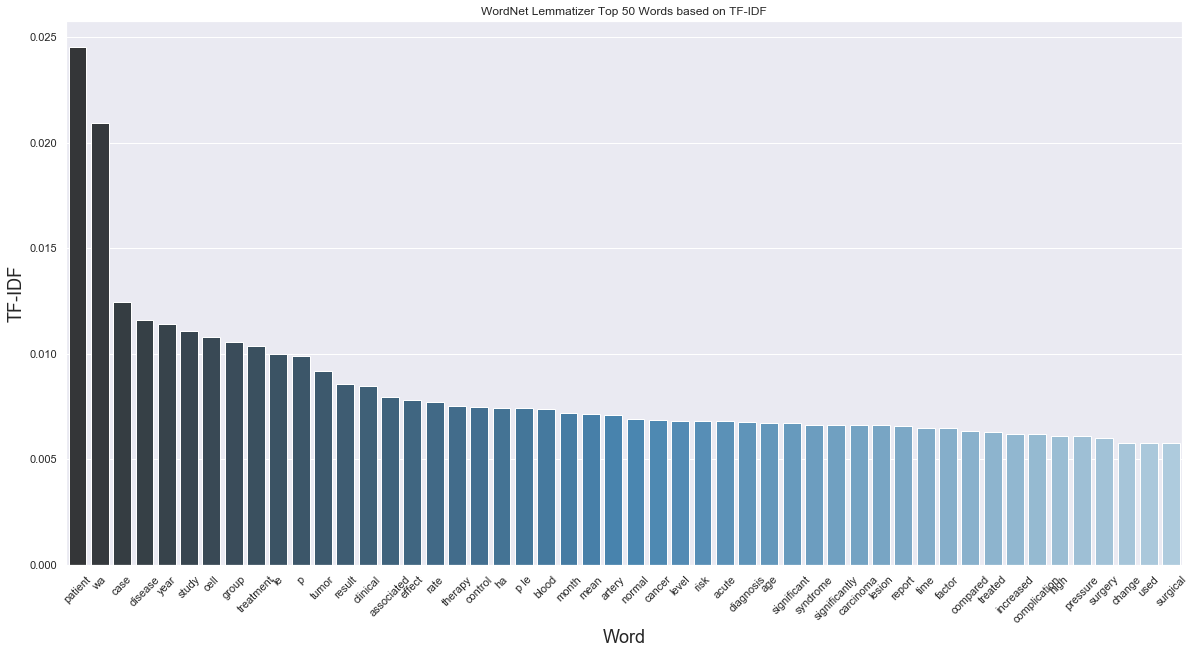

In [50]:
vocab_names = tfidf_vec.get_feature_names()

tfidf = np.mean(X_train_tfidf.toarray(), axis=0)

tfidf_df = pd.DataFrame.from_dict({'Word':vocab_names, 'TF-IDF':tfidf.ravel()})

# Set the graph parameters
sns.set(rc={"figure.figsize": (20.0, 10.0), "axes.labelsize": 18})

tfidf_top50 = tfidf_df.sort_values(['TF-IDF'], ascending=False).iloc[:50]

ax = sns.barplot("Word", "TF-IDF", data=tfidf_top50, palette="Blues_d");
ax.set_title('WordNet Lemmatizer Top 50 Words based on TF-IDF')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

In [51]:
N = 5
for i in sorted(train_df['Label'].unique()):
    features_chi2 = chi2(X_train_tfidf, train_df['Label'] == i)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vec.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("Class #%d:" % i)
    # Get last N values (np.argsort will return ascending values)
    print("  Most correlated unigrams:\n     *{}".format('\n     *'.join(unigrams[-N:])))
    print("  Most correlated bigrams:\n     *{}".format('\n     *'.join(bigrams[-N:])))

Class #1:
  Most correlated unigrams:
     *ktp
     *compartmental
     *tm
     *laci
     *audiogram
  Most correlated bigrams:
     *compared good
     *audit patient
     *compared final
     *standing history
     *physician assessment
Class #2:
  Most correlated unigrams:
     *msud
     *mpq
     *formulating
     *alteplase
     *tyrosinase
  Most correlated bigrams:
     *mutation coding
     *day mesna
     *renal adenocarcinoma
     *renal change
     *day menstrual
Class #3:
  Most correlated unigrams:
     *maculopapular
     *deoxycholate
     *synaptically
     *neurones
     *chord
  Most correlated bigrams:
     *lymphoma seven
     *lymphoma using
     *fusiform aneurysm
     *ventilator support
     *compensatory renal
Class #4:
  Most correlated unigrams:
     *nonsecreting
     *nonoxidative
     *nonmeasurable
     *normality
     *vesicourethral
  Most correlated bigrams:
     *normal pelvis
     *normal neurological
     *fatal subarachnoid
     *fat mass
     

In [52]:
class_top_tfidfs = top_feats_by_class(X_train_tfidf, Y_train, vocab_names, min_tfidf=0.1, top_n=25)

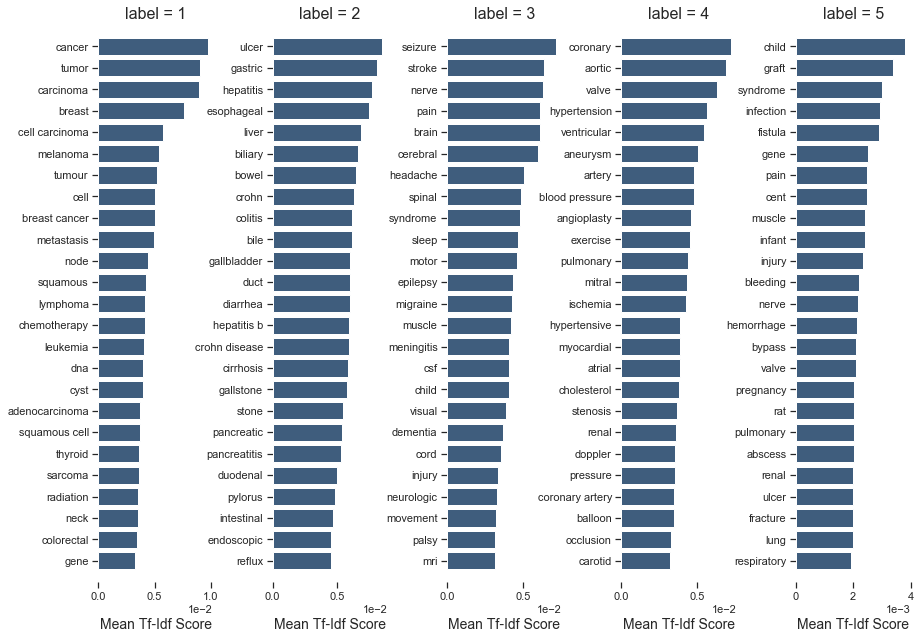

In [53]:
plot_tfidf(class_top_tfidfs)

## Porter Stemmer

In [54]:
# Using idf

tfidf_vec = TfidfVectorizer(tokenizer = tokenizer, norm='l2', ngram_range=(1,2), sublinear_tf = True, min_df = 5,
                            stop_words = stop_words)
tfidf_vec.fit(abstract_df.values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=frozenset({'any', 'here', 'seem', 'take', "aren't", 'least', 'off', 'alone', 'describe', 'couldn', 'mustn', 'wouldn', 'therein', 'thus', 'whole', 'whose', 'won', 'i', 'couldnt', 'none', 'own', 'front', 'beyond', 'thin', 'thru', 'been', 'across', 'nothing', 'whence', 'yourself', 'most', 's...pon', 'this', 'whereby', 'hers', 'while', 'all', 'because', 'both', 'six', 'm', 'between', 'haven'}),
        strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizer at 0x117c09598>, use_idf=True,
        vocabulary=None)

In [55]:
X_train_tfidf = tfidf_vec.transform(train_df['Abstract'].values)
X_test_tfidf = tfidf_vec.transform(test_df['Abstract'].values)

In [56]:
print('There are %i features' % X_train_tfidf.shape[1])

There are 102346 features


In [57]:
vocab_names = tfidf_vec.get_feature_names()

In [58]:
tfidf = np.mean(X_train_tfidf.toarray(), axis=0)

In [59]:
tfidf_df = pd.DataFrame.from_dict({'Word':vocab_names, 'TF-IDF':tfidf.ravel()})

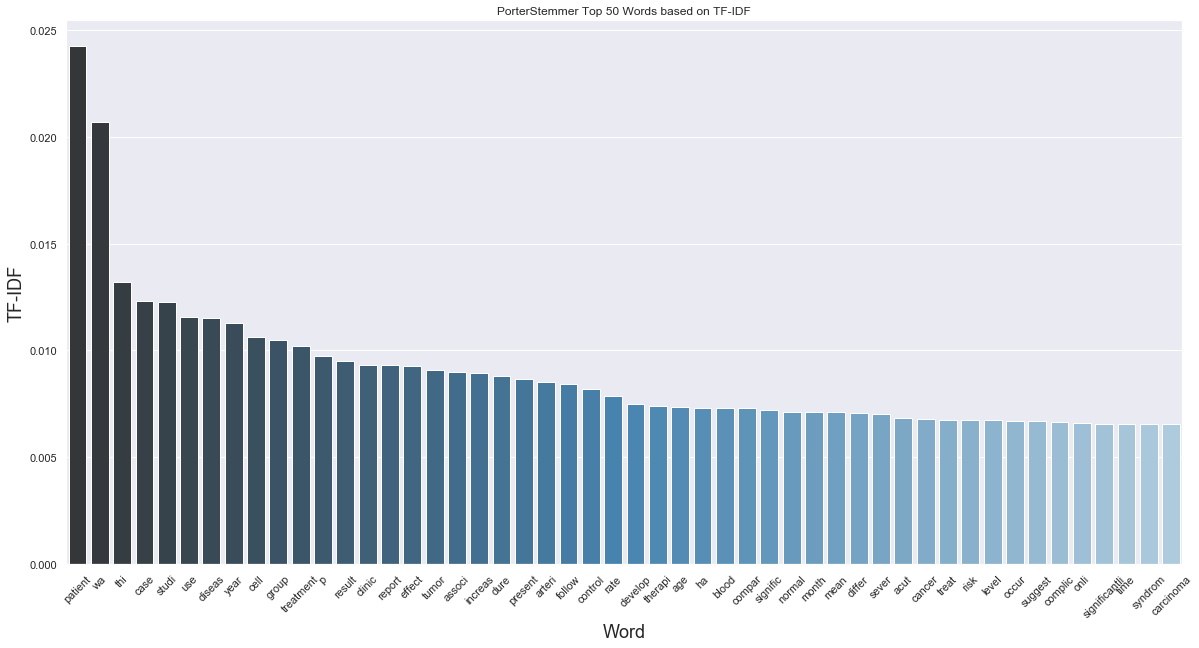

In [60]:
# Set the graph parameters
sns.set(rc={"figure.figsize": (20.0, 10.0), "axes.labelsize": 18})

tfidf_top50 = tfidf_df.sort_values(['TF-IDF'], ascending=False).iloc[:50]

ax = sns.barplot("Word", "TF-IDF", data=tfidf_top50, palette="Blues_d");
ax.set_title('PorterStemmer Top 50 Words based on TF-IDF')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

In [61]:
N = 5
for i in sorted(train_df['Label'].unique()):
    features_chi2 = chi2(X_train_tfidf, train_df['Label'] == i)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vec.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("Class #%d:" % i)
    # Get last N values (np.argsort will return ascending values)
    print("  Most correlated unigrams:\n     *{}".format('\n     *'.join(unigrams[-N:])))
    print("  Most correlated bigrams:\n     *{}".format('\n     *'.join(bigrams[-N:])))

Class #1:
  Most correlated unigrams:
     *visuo
     *extratempor
     *arnold
     *uncorrect
     *lymphangiomyomatosi
  Most correlated bigrams:
     *arrest like
     *f novel
     *arrest hospit
     *f fluorodopa
     *safeti toler
Class #2:
  Most correlated unigrams:
     *airborn
     *italiano
     *opercular
     *hpn
     *suprahyoid
  Most correlated bigrams:
     *surfac igm
     *arrest like
     *concentr brain
     *concentr baselin
     *result background
Class #3:
  Most correlated unigrams:
     *mpq
     *mph
     *soap
     *infarto
     *harbour
  Most correlated bigrams:
     *victim blunt
     *earli thrombolysi
     *cerebr spinal
     *neuron excit
     *bleed area
Class #4:
  Most correlated unigrams:
     *heater
     *cath
     *uur
     *gruppo
     *guanyl
  Most correlated bigrams:
     *pressur afterload
     *v hour
     *therefor hypothes
     *haemorrhag cerebr
     *gamma dose
Class #5:
  Most correlated unigrams:
     *peril
     *periumbil
    

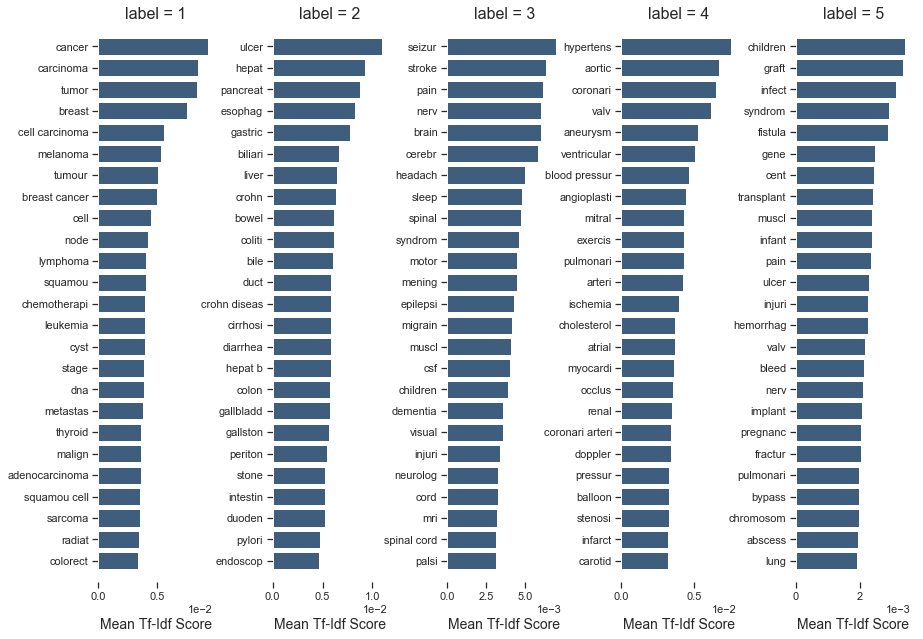

In [62]:
class_top_tfidfs = top_feats_by_class(X_train_tfidf, Y_train, vocab_names, min_tfidf=0.1, top_n=25)

plot_tfidf(class_top_tfidfs)